In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/My Drive/Khoa Luan/"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
import pandas as pd
test = pd.read_csv(path+"test3.csv")
test = test.dropna()
df = pd.read_csv(path+'data3.csv')
df = df.dropna()
print(df.head())
print(test.head())

   Unnamed: 0                                             review  label
0           0  chất_lượng sản_phẩm rất kém negative dán xong ...      0
1           1  đóng_gói sản_phẩm rất đẹp positive và chắc_chắ...      1
2           2                         qua khac thoi lan sau chiu      0
3           3                          ko duoc nhu hinh dinh kem      0
4           4  vua ve lai vn la phai lap tai khoan cua hang e...      1
   Unnamed: 0                                             review  label
0           0          chất_lượng sản_phẩm tuyệt_vời positive ok      1
1           1  hang rat tot positive va dep positive rat dang...      1
2           2  tôi hy_vọng positive vào cuốn sách này của tờ ...      0
3           3  chất_lượng sản_phẩm rất kém negative cửa_hàng ...      0
4           4  hàng không giống trong hình cái cỡ nhưng khi n...      0


Text(0.5, 1.0, 'Number of neg and pos messages')

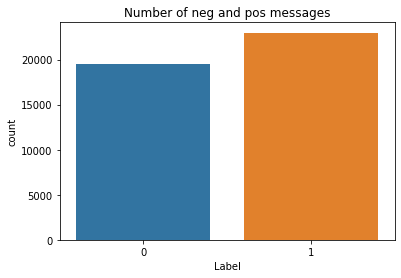

In [ ]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Number of neg and pos messages')

In [ ]:
data = df.review.tolist()
label = df.label.tolist()
data_test = test.review.tolist()
label_test = test.label.tolist()
data_n = []
for i in data:
  i = i.replace('_','')
  data_n.append(i)
test_v = []
for i in data_test:
  i = i.replace('_','')
  test_v.append(i)

In [ ]:
import pickle
with open(path + 'embeddings_index_vi.pickle', 'rb') as pickle_file:
    embeddings_index = pickle.load(pickle_file)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer  = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data_n)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

sequences =  tokenizer.texts_to_sequences(data_n)
# maxlen = max([len(i) for i in data_n])
maxlen = 300
data = pad_sequences(sequences, maxlen=maxlen)

le = LabelEncoder()

label = le.fit_transform(label)
labels = label.reshape(-1,1)
labels_test = le.fit_transform(label_test)
labels_test = labels_test.reshape(-1,1)
# labels = to_categorical(np.asarray(label))
# labels_test = to_categorical(np.asarray(label_test))
print('Shape of data tensor:', data.shape)
x_train,x_val,y_train,y_val = train_test_split(data,labels,test_size=0.15, random_state=48)

unique words : 26474
Shape of data tensor: (42516, 300)


In [ ]:
def convert_to_sequences(texts):
  sequences =  tokenizer.texts_to_sequences(texts)
  return pad_sequences(sequences, maxlen=maxlen)

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
print(300)
print(embedding_matrix.shape)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

300
(38213, 300)


In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(len(word_index)+1,300,input_length=maxlen)(inputs)
    layer = LSTM(units=256)(layer)
    layer = Dense(256,activation = 'relu')(layer)
    layer = Dense(1,activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
from keras.callbacks import ModelCheckpoint

model = RNN()
checkpoint = ModelCheckpoint(path + 'Test/weights_lstm_NCT_SV_fastext_sentece.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          11463900  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 12,100,317
Trainable params: 12,100,317
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train,y_train,batch_size=128,epochs=10,verbose=1,
          callbacks=[checkpoint], validation_data=[x_val,y_val])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 34646 samples, validate on 6114 samples
Epoch 1/10
34646/34646 [==============================] - 181s 5ms/step - loss: 0.3567 - accuracy: 0.8473 - val_loss: 0.2975 - val_accuracy: 0.8801

Epoch 00001: val_accuracy improved from -inf to 0.88011, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_lstm_NCT_SV_fastext_sentece.hdf5
Epoch 2/10
34646/34646 [==============================] - 181s 5ms/step - loss: 0.2445 - accuracy: 0.9043 - val_loss: 0.2969 - val_accuracy: 0.8804

Epoch 00002: val_accuracy improved from 0.88011 to 0.88044, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_lstm_NCT_SV_fastext_sentece.hdf5
Epoch 3/10
34646/34646 [==============================] - 182s 5ms/step - loss: 0.2098 - accuracy: 0.9181 - val_loss: 0.3374 - val_accuracy: 0.8538

Epoch 00003: val_accuracy did not improve from 0.88044
Epoch 4/10
34646/34646 [==============================] - 181s 5ms/step - loss: 0.1822 - accuracy: 0.9309 - val_loss: 0.3389 - val_accuracy:

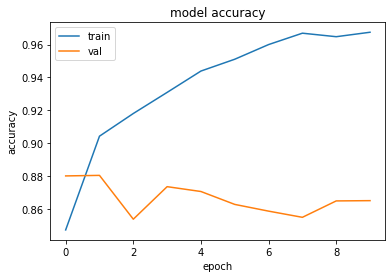

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

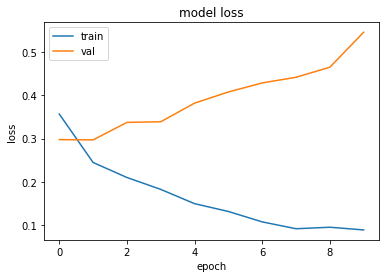

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model(path + 'Test/weights_lstm_data3_fastext_sentece.hdf5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
from sklearn import metrics
acc = model.predict(convert_to_sequences(test_v))
accr = np.round(acc)
print(metrics.f1_score(labels_test, accr))
print(metrics.precision_score(labels_test, accr))
print(metrics.recall_score(labels_test, accr))

0.8750685933784524
0.8859259259259259
0.8644741597397904
